### MNIST - ANN and CNN

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


#### Data Querying

In [2]:
# Pull data in form of Tensors
transforms = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transforms)

#### Exploring the data

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [6]:
image, label = train_data[0]
print(image.shape)

torch.Size([1, 28, 28])


label: 0


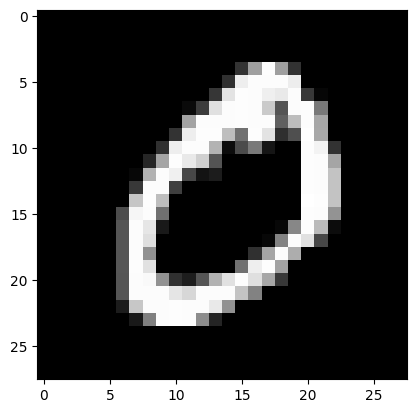

In [7]:
plt.imshow(train_data[1][0].reshape((28,28)), cmap="gray")
print(f'label: {train_data[1][1]}')

#### Data -> Batch

In [8]:
train_data_load = DataLoader(train_data, batch_size=100, shuffle=True)
test_data_load = DataLoader(test_data, batch_size=100, shuffle=False)

In [9]:
for image_1,label_1 in train_data_load: 
    break

In [10]:
image_1.shape

torch.Size([100, 1, 28, 28])

In [11]:
len(label_1.unique())

10

#### Model - ANN

In [12]:
class ANN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(in_features=28*28, out_features=128)
        self.fc2=nn.Linear(in_features=128, out_features=64)
        self.fc3=nn.Linear(in_features=64, out_features=32)
        self.fc4=nn.Linear(in_features=32, out_features=10)


    def forward(self, X):
        X= F.relu(self.fc1(X))
        X= F.relu(self.fc2(X))
        X= F.relu(self.fc3(X))
        X= F.log_softmax(self.fc4(X), dim=1)
        return X

In [13]:
model_ann = ANN_model()
model_ann

ANN_model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [14]:
param_list=[]
for params in model_ann.parameters():
    param_list.append(params.numel())
print(f'#Parameters: {param_list}')
print(f'Total parameters: {sum(param_list)}')

#Parameters: [100352, 128, 8192, 64, 2048, 32, 320, 10]
Total parameters: 111146


#### Loss function and optimiser

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer_ann = torch.optim.Adam(model_ann.parameters(), lr=0.001)

#### Train ANN

In [16]:
epochs = 8

train_loss_ann = []
test_loss_ann = []
train_corr_ann = []
test_corr_ann = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_data_load):
        b+=1
        
        optimizer_ann.zero_grad()
        y_pred = model_ann(X_train.reshape(100, -1))
        loss = criterion(y_pred, y_train)

        pred = torch.max(y_pred.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        train_corr += batch_corr

        
        loss.backward()
        optimizer_ann.step()
    

    train_loss_ann.append(loss.item())
    train_corr_ann.append(train_corr.item())
    print(f'Training Epoch: {i}, Loss: {loss.item()}, Accuracy: {train_corr.item()/b}')
 
    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_data_load):
            b+=1

            y_test_pred = model_ann(X_test.reshape(100,-1))
            
            pred = torch.max(y_test_pred.data, 1)[1]
            test_corr += (pred == y_test).sum()

    loss = criterion(y_test_pred, y_test)
    test_loss_ann.append(loss.item())
    test_corr_ann.append(test_corr.item())

    print(f'Testing Epoch: {i}, Loss: {loss.item()}, Accuracy: {test_corr.item()/b}')



Training Epoch: 0, Loss: 0.25139161944389343, Accuracy: 86.82833333333333
Testing Epoch: 0, Loss: 0.33480894565582275, Accuracy: 93.56
Training Epoch: 1, Loss: 0.1316884458065033, Accuracy: 95.115
Testing Epoch: 1, Loss: 0.15826304256916046, Accuracy: 95.94
Training Epoch: 2, Loss: 0.10831685364246368, Accuracy: 96.46166666666667
Testing Epoch: 2, Loss: 0.14249370992183685, Accuracy: 96.15
Training Epoch: 3, Loss: 0.08415906876325607, Accuracy: 97.31
Testing Epoch: 3, Loss: 0.11678580194711685, Accuracy: 96.96
Training Epoch: 4, Loss: 0.10655511170625687, Accuracy: 97.75
Testing Epoch: 4, Loss: 0.11103331297636032, Accuracy: 96.74
Training Epoch: 5, Loss: 0.04263543710112572, Accuracy: 98.15
Testing Epoch: 5, Loss: 0.07933734357357025, Accuracy: 97.52
Training Epoch: 6, Loss: 0.05786852911114693, Accuracy: 98.43666666666667
Testing Epoch: 6, Loss: 0.05887825787067413, Accuracy: 97.48
Training Epoch: 7, Loss: 0.11934015154838562, Accuracy: 98.72666666666667
Testing Epoch: 7, Loss: 0.078

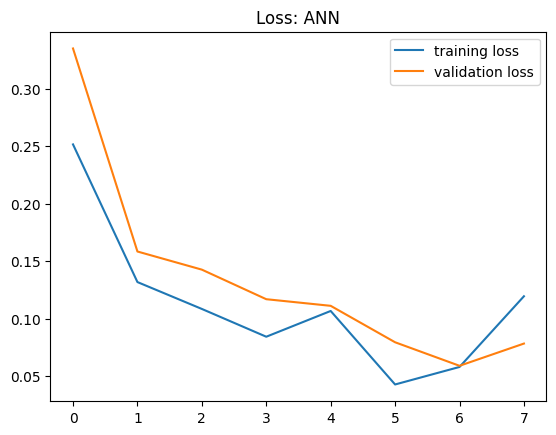

In [17]:
plt.plot(train_loss_ann, label='training loss')
plt.plot(test_loss_ann, label='validation loss')
plt.title('Loss: ANN')
plt.legend()

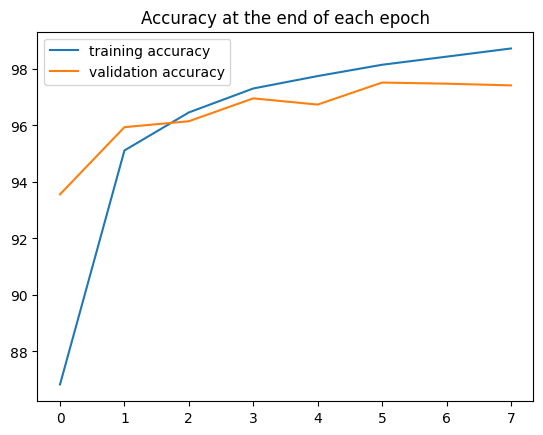

In [18]:
plt.plot([t/600 for t in train_corr_ann], label='training accuracy')
plt.plot([t/100 for t in test_corr_ann], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

#### Model - CNN

In [52]:
class CNN_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1= nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2)
        self.conv2= nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        self.fc1=nn.Linear(in_features=16*1*1, out_features=64)
        self.fc2=nn.Linear(in_features=64, out_features=10)
        # self.fc3=nn.Linear(in_features=32, out_features=10)

    def forward(self, X):
        X= F.max_pool2d(F.relu(self.conv1(X)), kernel_size=2, stride=2)
        X= F.max_pool2d(F.relu(self.conv2(X)), kernel_size=2, stride=2)
        X=X.view(-1, 16*1*1)
        X= F.relu(self.fc1(X))
        # X= F.relu(self.fc2(X))
        X=F.log_softmax(self.fc2(X), dim=1)
        return X


In [53]:
model_cnn = CNN_model()
model_cnn

CNN_model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [54]:
param_list=[]
for params in model_cnn.parameters():
    param_list.append(params.numel())
print(f'#Parameters: {param_list}')
print(f'Total parameters: {sum(param_list)}')

#Parameters: [72, 8, 1152, 16, 1024, 64, 640, 10]
Total parameters: 2986


In [55]:
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.002)

### Train CNN

In [56]:
epochs = 8

train_loss_cnn = []
test_loss_cnn = []
train_corr_cnn = []
test_corr_cnn = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_data_load):
        b+=1
        
        optimizer_cnn.zero_grad()
        y_pred = model_cnn(X_train)
        loss = criterion(y_pred, y_train)

        pred = torch.max(y_pred.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        train_corr += batch_corr

        
        loss.backward()
        optimizer_cnn.step()
    

    train_loss_cnn.append(loss.item())
    train_corr_cnn.append(train_corr.item())
    print(f'Training Epoch: {i}, Loss: {loss.item()}, Accuracy: {train_corr.item()/b}')
 
    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_data_load):
            b+=1

            y_test_pred = model_cnn(X_test)
            
            pred = torch.max(y_test_pred.data, 1)[1]
            test_corr += (pred == y_test).sum()

    loss = criterion(y_test_pred, y_test)
    test_loss_cnn.append(loss.item())
    test_corr_cnn.append(test_corr.item())

    print(f'Testing Epoch: {i}, Loss: {loss.item()}, Accuracy: {test_corr.item()/b}')

Training Epoch: 0, Loss: 0.43199053406715393, Accuracy: 75.77166666666666
Testing Epoch: 0, Loss: 0.4860170781612396, Accuracy: 88.24
Training Epoch: 1, Loss: 0.416410356760025, Accuracy: 89.22166666666666
Testing Epoch: 1, Loss: 0.3648796081542969, Accuracy: 91.22
Training Epoch: 2, Loss: 0.17376179993152618, Accuracy: 91.22833333333334
Testing Epoch: 2, Loss: 0.3648490607738495, Accuracy: 92.75
Training Epoch: 3, Loss: 0.10343245416879654, Accuracy: 92.39833333333333
Testing Epoch: 3, Loss: 0.34145495295524597, Accuracy: 93.33
Training Epoch: 4, Loss: 0.2756354510784149, Accuracy: 92.99166666666666
Testing Epoch: 4, Loss: 0.28307053446769714, Accuracy: 93.78
Training Epoch: 5, Loss: 0.294153094291687, Accuracy: 93.55833333333334
Testing Epoch: 5, Loss: 0.2846166491508484, Accuracy: 94.27
Training Epoch: 6, Loss: 0.1506548374891281, Accuracy: 94.09833333333333
Testing Epoch: 6, Loss: 0.28573569655418396, Accuracy: 93.91
Training Epoch: 7, Loss: 0.18281103670597076, Accuracy: 94.356666

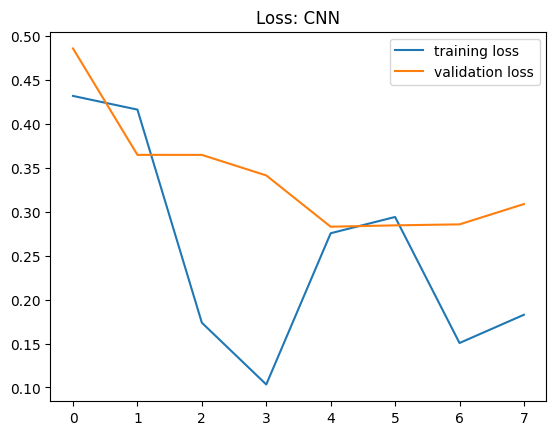

In [57]:
plt.plot(train_loss_cnn, label='training loss')
plt.plot(test_loss_cnn, label='validation loss')
plt.title('Loss: CNN')
plt.legend()

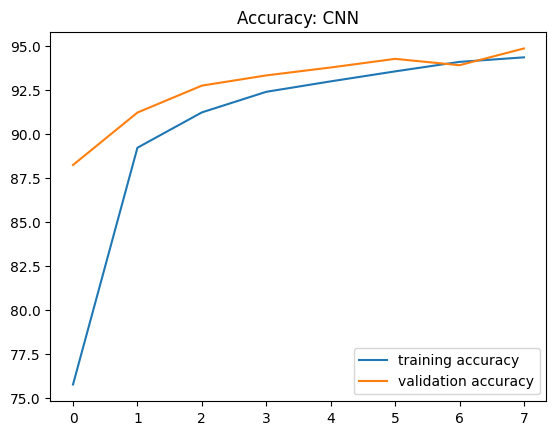

In [58]:
plt.plot([t/600 for t in train_corr_cnn], label='training accuracy')
plt.plot([t/100 for t in test_corr_cnn], label='validation accuracy')
plt.title('Accuracy: CNN')
plt.legend()